<a href="https://colab.research.google.com/github/skrofman/Applied-Machine-Learning/blob/master/DATA_310_Lecture_15_Spring_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA 310 Lecture 15 - Spring 2021

<font face="Chalkboard" color="darkgreen" size=10> VALIDATION</font>

### The main idea is that we want an unbiased estimator.

<font color='red' > Keywords: unbiased, estimator, MSE. </font>

 - estimator: is your model output, the way you decided to predict in machine learning

 - unbiased: when the results produced by our model on a training sample approach in probability the results that would have been obtained on the whole "population". The method we can use in this case K-Fold cross-validation.

 - MSE: it means mean square error - the average of the sum of the squared residuals (for regression).

Concepts to include in discussion: underfit/overfit models, K-fold cross validation.

In [ ]:
# general imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Load a regression dataset, i.e. https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength
df = pd.read_csv('drive/MyDrive/Colab Notebooks/concrete.csv')
# we get the input and the output as numerical arrays
y = df['strength'].values
X = df.loc[ : , df.columns != 'strength'].values
Xf = df.loc[ : , df.columns != 'strength']

In [ ]:
X.shape

(1030, 8)

In [ ]:
# this is the coefficient of determination aka R^2
def R2(yhat,y):
  return 1 - np.sum((y-yhat)**2)/np.sum((y-np.mean(y))**2)

In [ ]:
X.shape # this does not need anything special

(1030, 8)

In [ ]:
from scipy import stats
n = len(X)
r = -0.12
# test statistic 
t = r*np.sqrt(n-2)/np.sqrt(1-r**2)
pval = stats.t.sf(np.abs(t), n-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
print('t-statistic = %6.3f pvalue = %6.4f' % (t, pval))

t-statistic = -3.875 pvalue = 0.0001


In [ ]:
def tstat_corr(r,n):
  t = r*np.sqrt(n-2)/np.sqrt(1-r**2)
  pval = stats.t.sf(np.abs(t), n-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
  print('t-statistic = %6.3f pvalue = %6.4f' % (t, pval))


In [ ]:
tstat_corr(0.1,len(X))

t-statistic =  3.222 pvalue = 0.0013


In [ ]:
feature_names = df.columns

### Message: we got strong multiple linear correlations among the input features so we NEED regularization because we are in "rank deffficient situation"

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [ ]:
sns.set(color_codes=True)
cols = Xf.columns
sns.heatmap(np.corrcoef(np.transpose(X)),cmap='bwr',vmin=-1,vmax=1,annot=True,fmt='.2f',xticklabels=cols,yticklabels=cols)
plt.show()

In [ ]:
tstat_corr(0.09,len(X))
# yes this is a significant correlation that we cannot neglect !

t-statistic =  2.897 pvalue = 0.0038


In [ ]:
tstat_corr(-0.26,len(X))
# this is very significant !!

t-statistic = -8.633 pvalue = 0.0000


In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=2021)
Xs_train = scale.fit_transform(X_train)
Xs_test  = scale.transform(X_test)

In [ ]:
model = ElasticNet(alpha=0.01,l1_ratio=0.01)
model.fit(Xs_train, y_train)
yhat =  model.predict(Xs_test)
residuals = y_test - yhat

In [ ]:
# this is the coefficient of determination aka R^2
def R2(yhat,y):
  return 1 - np.sum((y-yhat)**2)/np.sum((y-np.mean(y))**2)

In [ ]:
R2(yhat,y_test)

0.5620465222466524

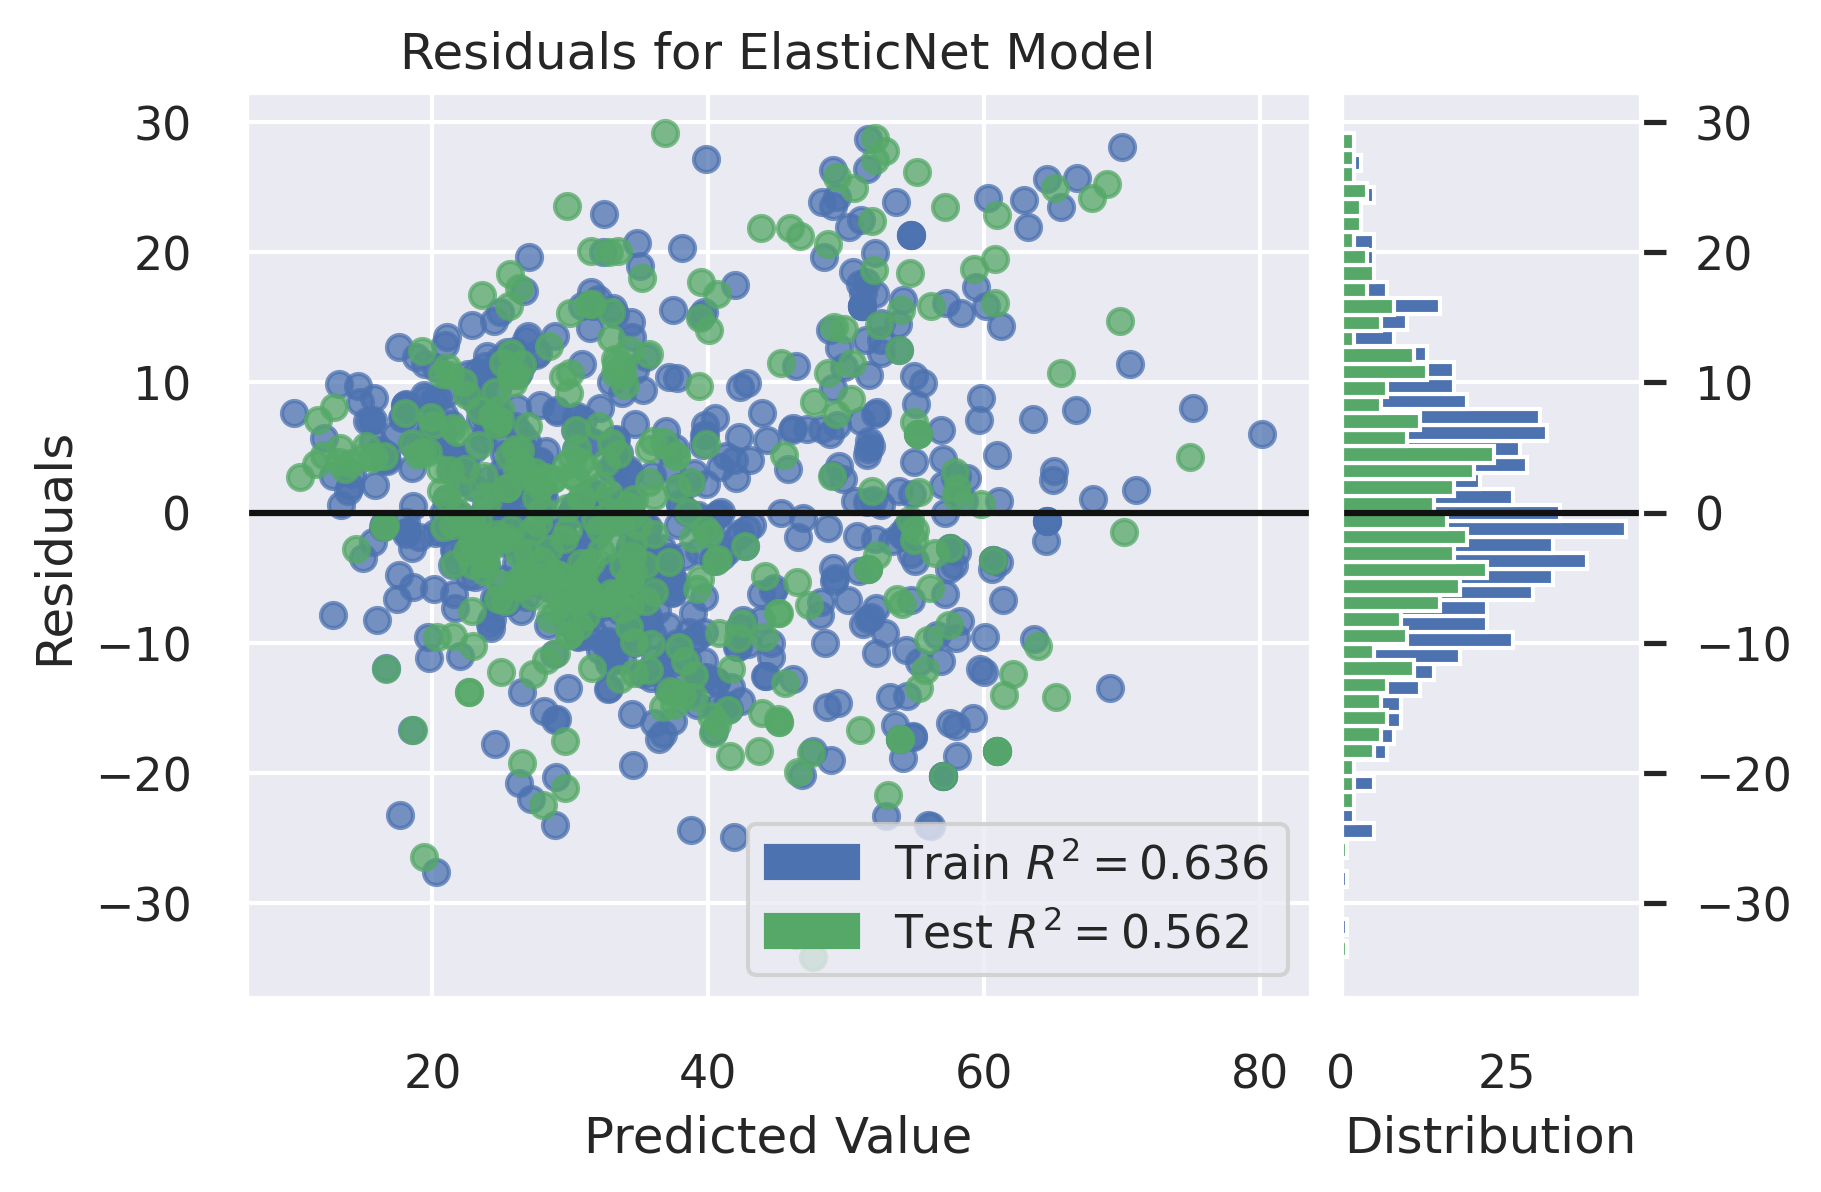

In [ ]:

visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

In [ ]:
# import distributions
from scipy import stats
from scipy.stats import norm

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Residuals')]

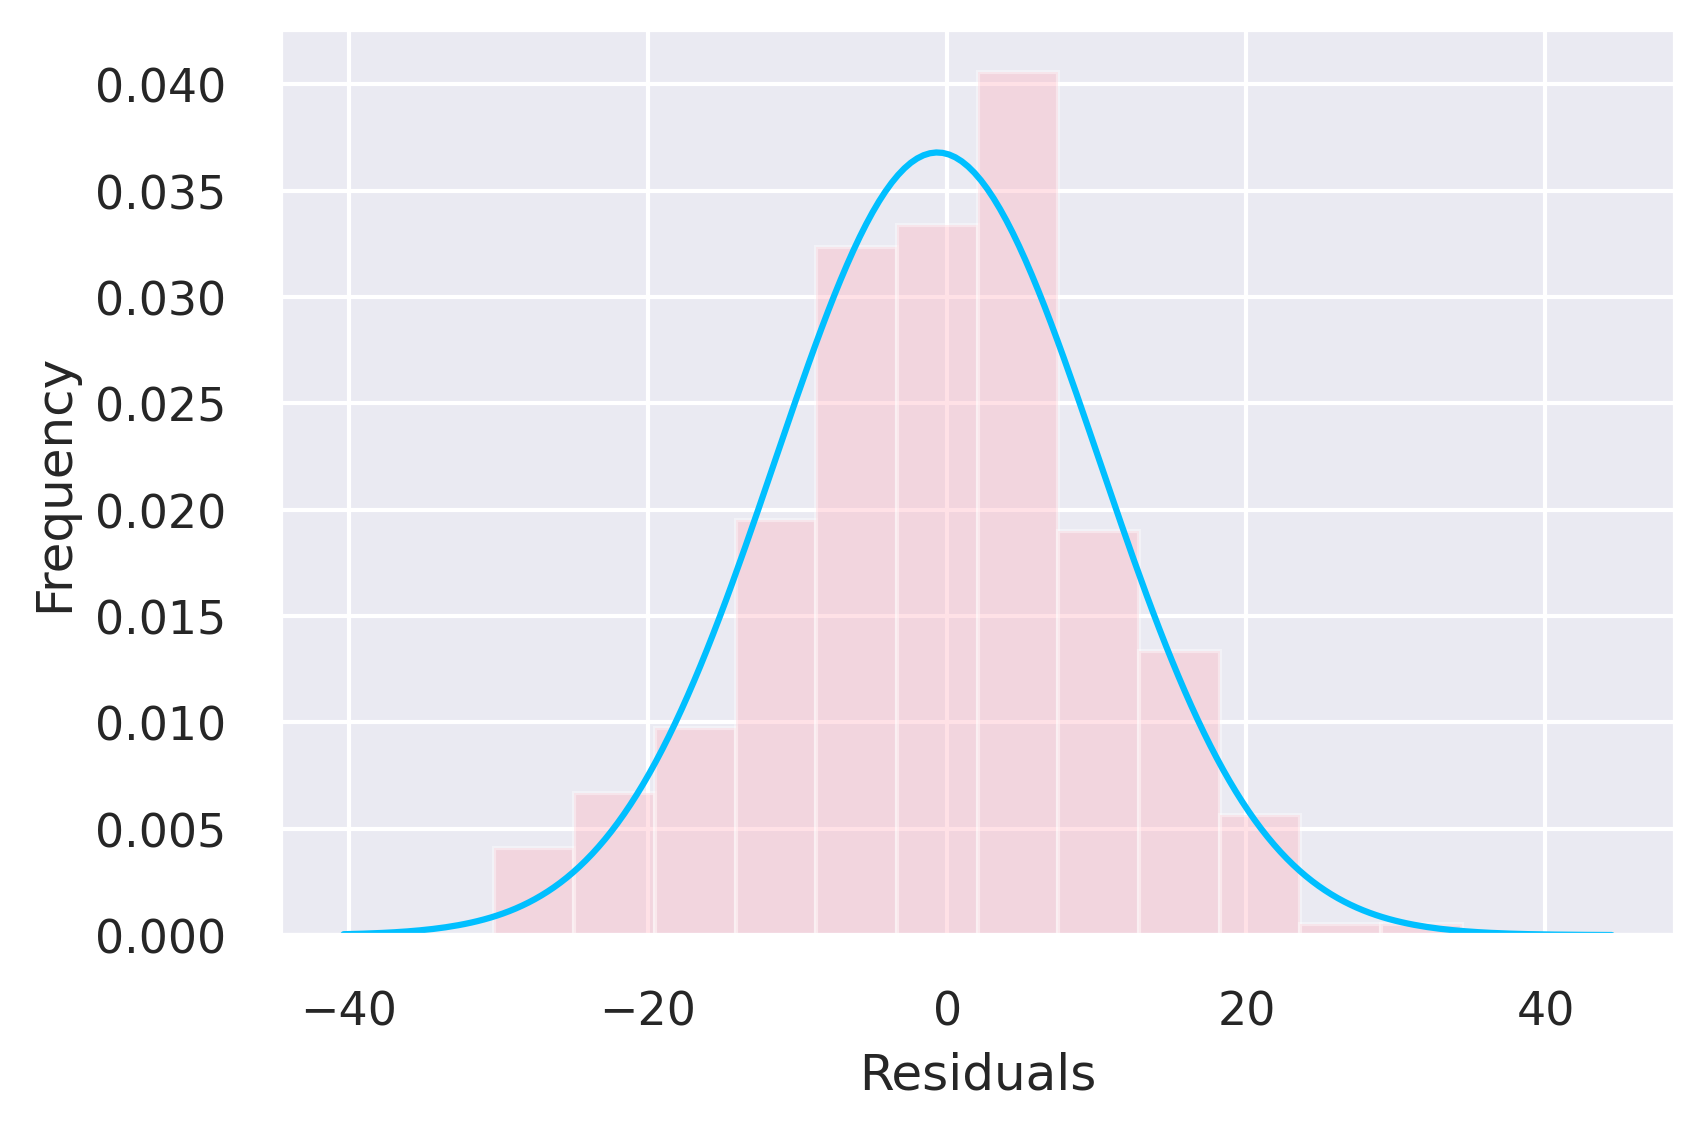

In [ ]:
ax1 = sns.distplot(residuals,
                                        
                  bins=12,
                  kde=False,
                  color='deepskyblue',
                  hist_kws={"color":'lightpink'},
                  fit=stats.norm,
                  fit_kws={"color":'deepskyblue'})
ax1.set(xlabel='Residuals', ylabel='Frequency')

In [ ]:
test, p = stats.shapiro(residuals)
print('The p-value (for having occurred by chance in a good match) is : '+str(p))

The p-value (for having occurred by chance in a good match) is : 0.18180964887142181


In [ ]:
import pylab
import statsmodels.api as sm
sm.qqplot(residuals, loc = 0, scale = 1, line='s')
pylab.show()

<font color='red'>Now let's try to create a non-linear function in the weights:

## <font color='blue'> Polynomial Regression</font>

<font color='slateblue'> Main idea: Linear combination of different powers of the feature values.

$$\large
P(x):= \beta_px^p+\beta_{p-1}x^{p-1}+...+\beta_1x+\beta_0
$$

IMPORTANT: P(x) is nonlinear in x. However if x is fixed (x is your data) and $\beta$ is the input we have
$$\large
P(\beta):= \beta_px^p+\beta_{p-1}x^{p-1}+...+\beta_1x+\beta_0
$$

Example of a cubic polynomial:

$$p(x) = 5x^3-7x^2+2.3x-17$$

is linear in $\beta$


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("ticks")

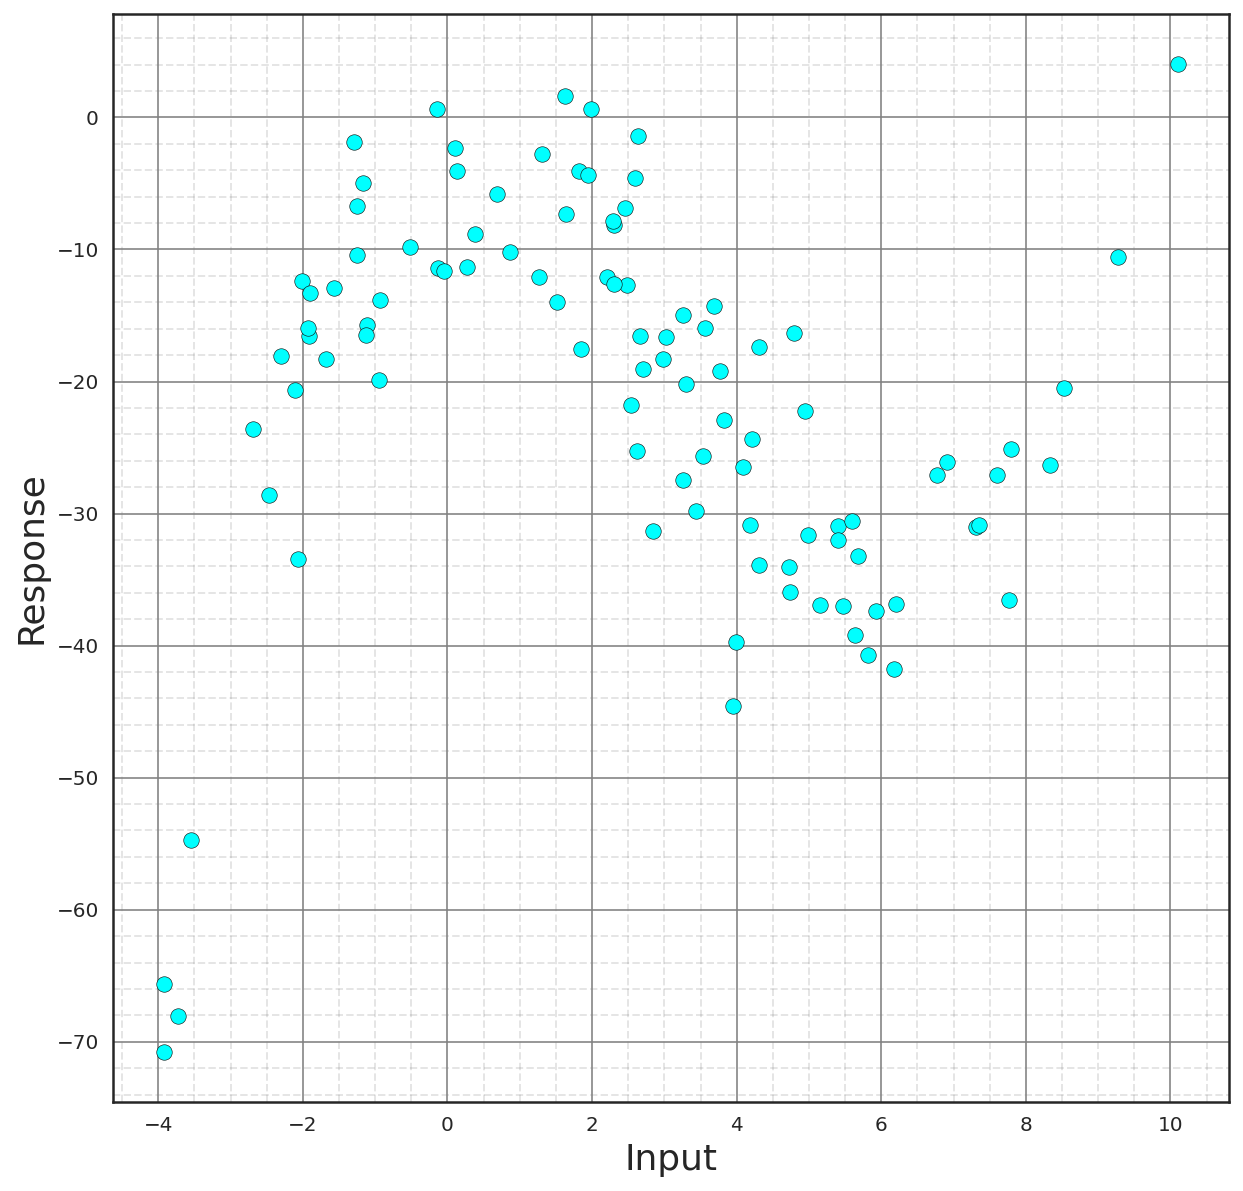

In [ ]:
np.random.seed(1693)
x = 2 - 3 * np.random.normal(0, 1, 100)
y = x - 2.5 * (x ** 2) + .25 * (x ** 3) + 2*np.random.normal(-3, 3, 100)
fig,ax = plt.subplots(figsize=(10,10))
plt.scatter(x,y,color='cyan',edgecolor='k',s=60)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Response',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

### <font color='purple'> Is a straight line a good idea for capturing the aspect?

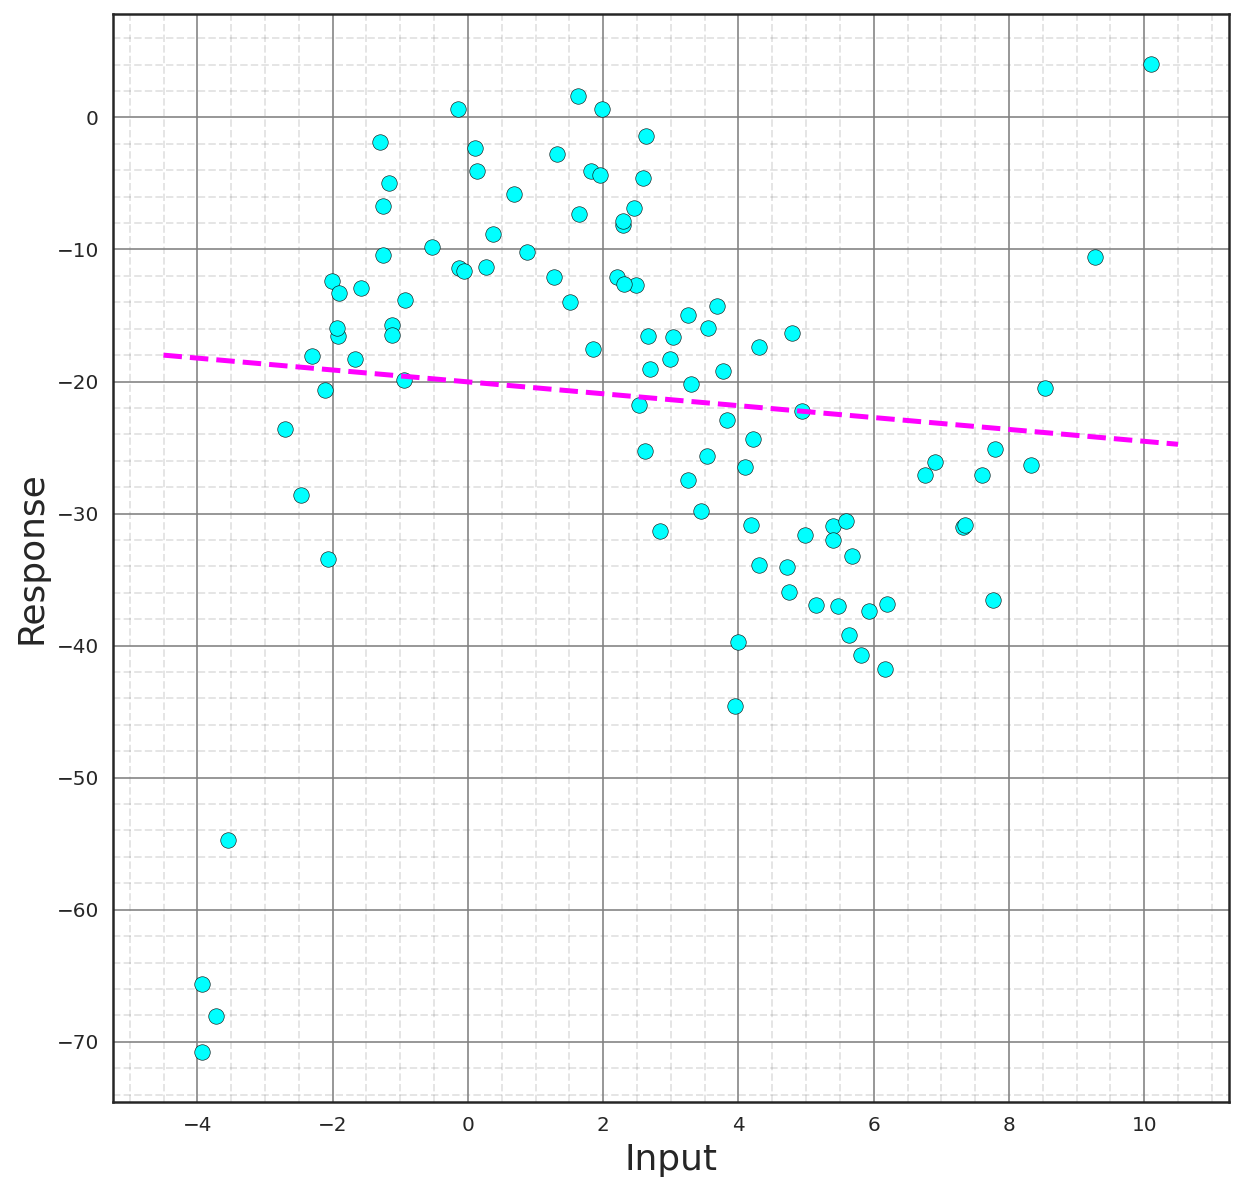

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

model = lm.fit(x.reshape((-1,1)),y)
y_pred = lm.predict(np.array([-5, 11]).reshape(-1, 1))
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
plt.plot([-4.5, 10.5], y_pred, '-',color='magenta',linestyle='--',lw=2.5)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Response',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [ ]:
import operator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x.reshape((-1,1)))
df_poly = pd.DataFrame(data=x_poly)
df_poly

,0,1,2,3
0,1.0,4.741352,22.480420,106.587590
1,1.0,3.554897,12.637292,44.924268
2,1.0,0.105749,0.011183,0.001183
3,1.0,1.626725,2.646233,4.304692
4,1.0,3.252754,10.580411,34.415480
...,...,...,...,...
95,1.0,-1.257303,1.580812,-1.987560
96,1.0,3.685663,13.584110,50.066446
97,1.0,3.253514,10.585350,34.439581
98,1.0,-3.928013,15.429287,-60.606442


6.443967644634602
0.8031091286451624


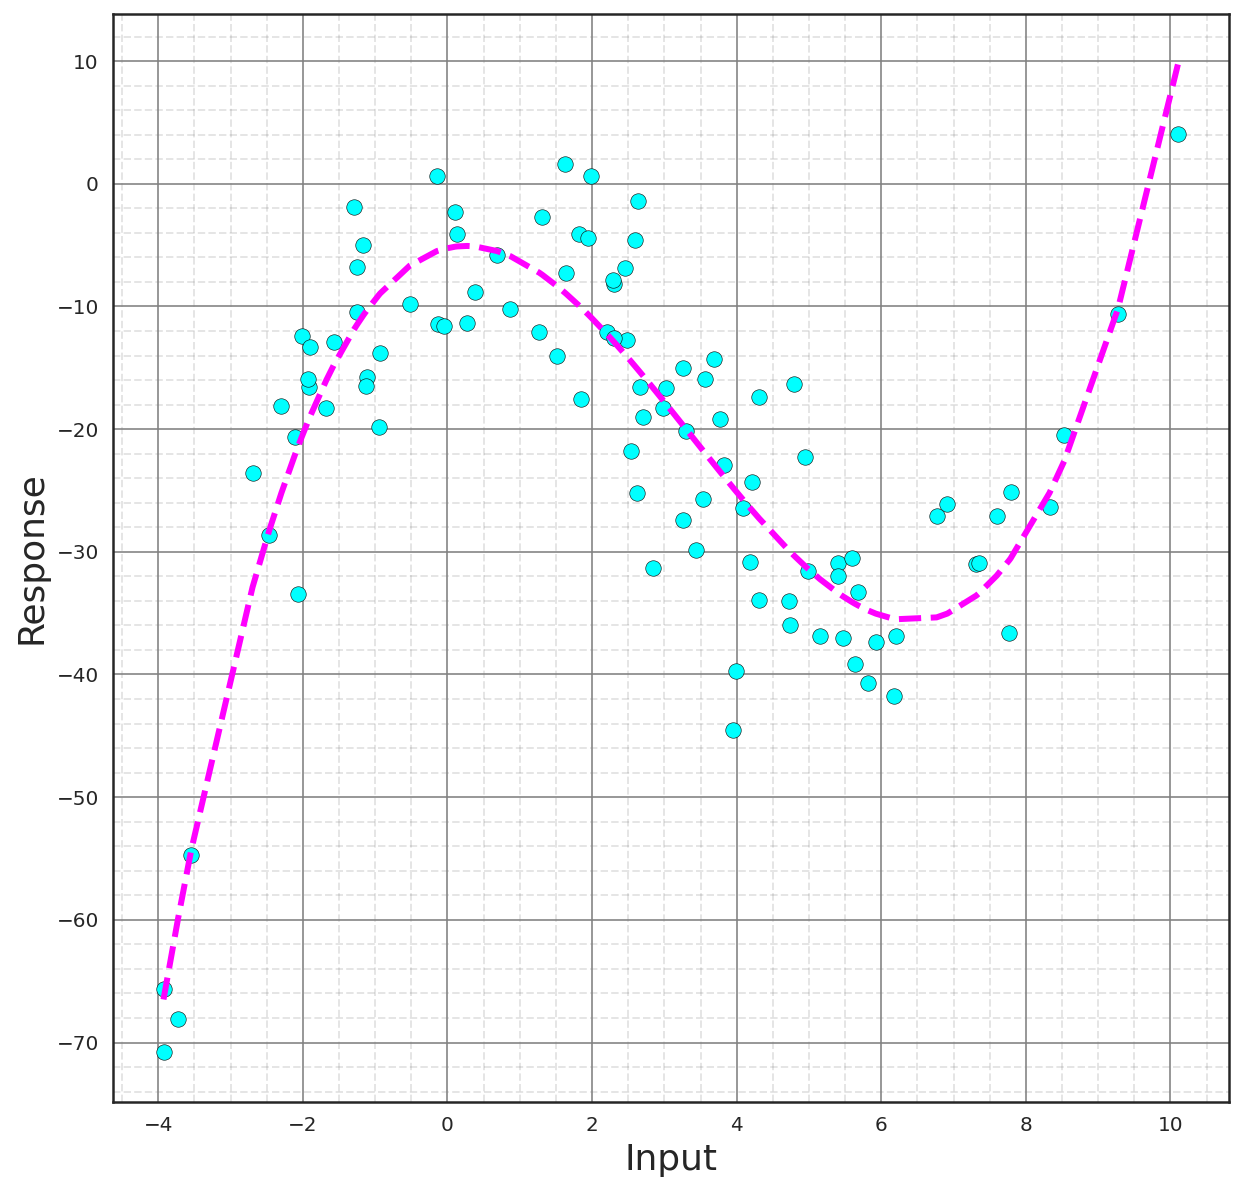

In [ ]:
np.random.seed(1693)
x = 2 - 3 * np.random.normal(0, 1, 100)

# this was the ground truth
def f(x):
    sz = len(x)
    return x - 2.5 * (x ** 2) + .25 * (x ** 3) + 2 * np.random.normal(-3, 3, sz)

y = f(x)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x.reshape((-1,1)))

# the model created is linear in weights 
#model = Lasso(alpha=0.5)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

# the root mean squared error
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))

# the coeffcient of determination
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
ax.plot(x, y_poly_pred, color='magenta',linestyle='--',lw=3)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Response',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [ ]:
poly = PolynomialFeatures(degree=4)
model = LinearRegression()

In [ ]:
np.random.seed(2021)
x = 2 - 3 * np.random.normal(0, 1, 12)

# this was the ground truth
def f(x):
    sz = len(x)
    return x - 2.5 * (x ** 2) + .25 * (x ** 3) + 2 * np.random.normal(-3, 3, sz)

y = f(x)

In [ ]:
x

array([-2.46582716, -0.02803261,  3.25535411,  4.41956244,  0.33237251,
        4.11651286, -1.39257479,  0.06499449,  1.68075877,  0.73353551])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2021)
x_poly_train = poly.fit_transform(np.array(x_train).reshape(-1,1))
x_poly_test = poly.fit_transform(np.array(x_test).reshape(-1,1))
model.fit(x_poly_train,y_train)
yhat_train = model.predict(x_poly_train)
yhat_test = model.predict(x_poly_test)
print('The MSE for the Train data is : '+str(mean_squared_error(y_train,yhat_train)))
print('The MSE for the Test data is : '+str(mean_squared_error(y_test,yhat_test)))

The MSE for the Train data is : 27.853458116062402
The MSE for the Test data is : 126.89862235375004


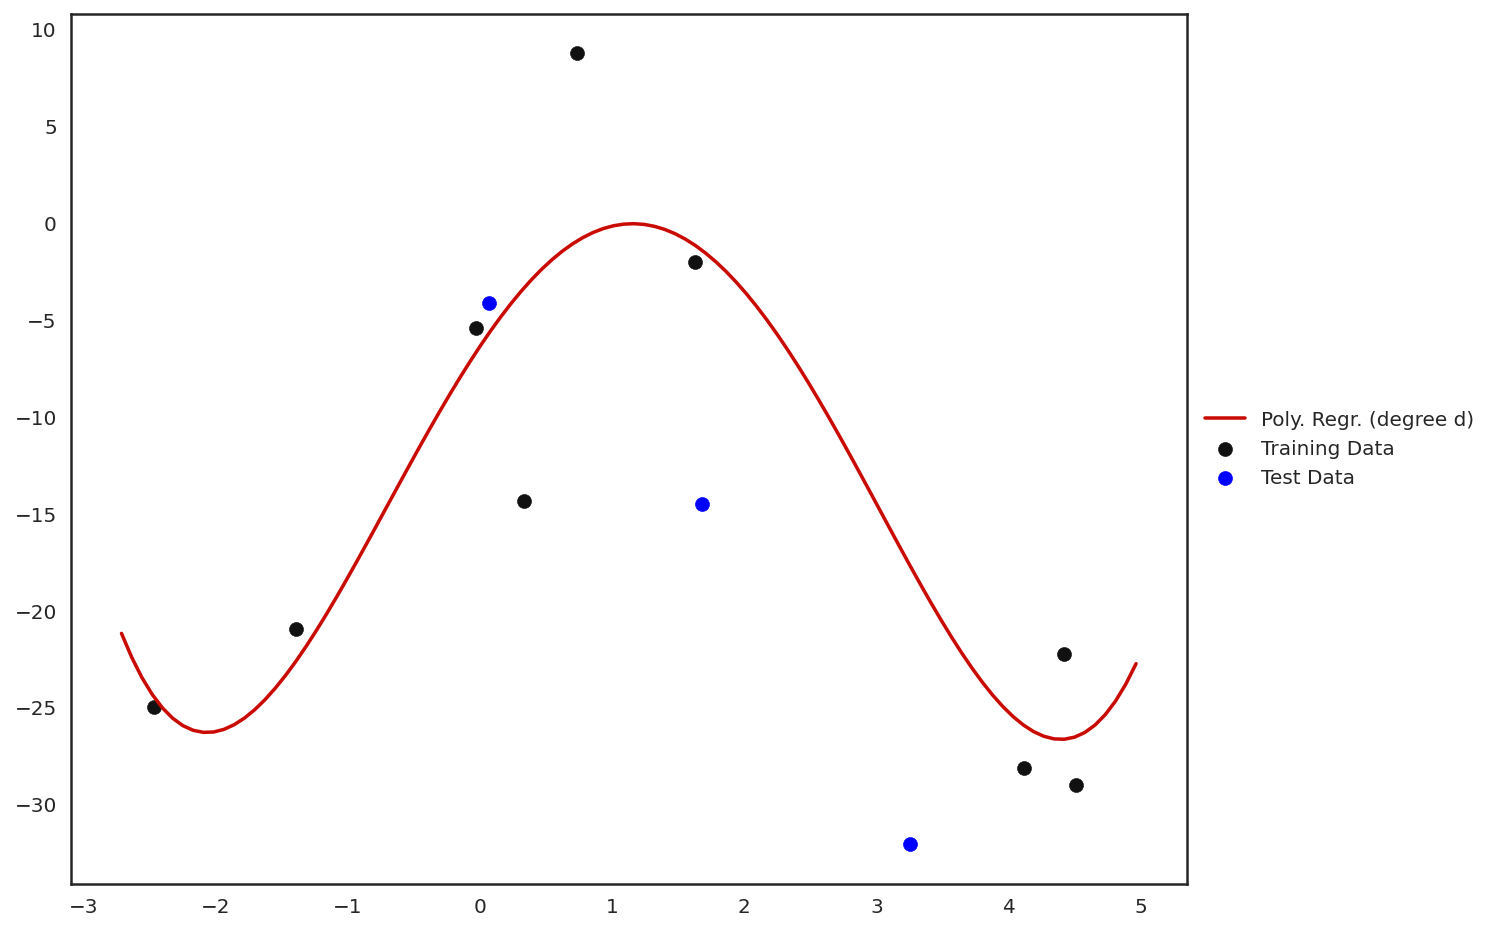

In [ ]:
# Compute the polynomial curve over a range of x values (for visualization)
x_range = np.linspace(np.min(x)*1.1,np.max(x)*1.1,100)
x_range_poly = poly.fit_transform(x_range.reshape(-1,1))
y_pred = model.predict(x_range_poly)

# Plot the data, the model, and the "hidden" test points
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x_train, y_train,color='k',label='Training Data')
ax.plot(x_range,y_pred, color='r', label='Poly. Regr. (degree d)')
ax.scatter(x_test, y_test, color='blue',label='Test Data')
#plt.ylim([-5,5])
plt.legend(bbox_to_anchor=[1,0.5],loc='center left')
plt.show()

###Overfit: if MSE on the Train set is much lower than the MSE on the Test set.

In [ ]:
np.array(x_train)

array([ 2.29269944,  4.31004774,  4.9413784 ,  1.84518443,  4.18378266,
        3.82573936, -2.00864269,  8.32670464,  0.10574859,  5.67528609,
        3.98712795, -1.25014167,  7.78849131, 10.10442638,  3.77470118,
       -1.91793672,  2.69963365,  6.19786788,  2.2069738 ,  1.94665017,
       -1.29626351,  5.59380119, -1.1641051 ,  9.27378371, -1.12120705,
        1.62672463, -1.93100015, -0.12948727,  6.91341572,  1.98953566,
       -1.57569707,  1.8181358 ,  5.15405068, -2.47024346,  2.66296012,
        2.84777065,  2.6217978 , -1.25730334,  2.59408329,  3.6856627 ,
        2.53380259,  3.94791502, -0.04994172, -3.92776671, -2.1096575 ,
        1.27042413,  6.16910234,  4.21167836, -1.89972275, -0.15131977,
       -0.94855617,  0.27090002,  7.31423343,  3.55489685,  2.29777286,
        5.92576257,  7.76860444, -3.92801312,  3.25275443,  5.81739232])

##<font color='blue'> Non-Linear that is not exactly a polynomial: A noisy sine wave</font>

In [ ]:
x = np.linspace(0,3.14,100)
epsilon = np.random.normal(scale=0.2,size=x.shape)
y = np.sin(4*x) + epsilon

In [ ]:
x

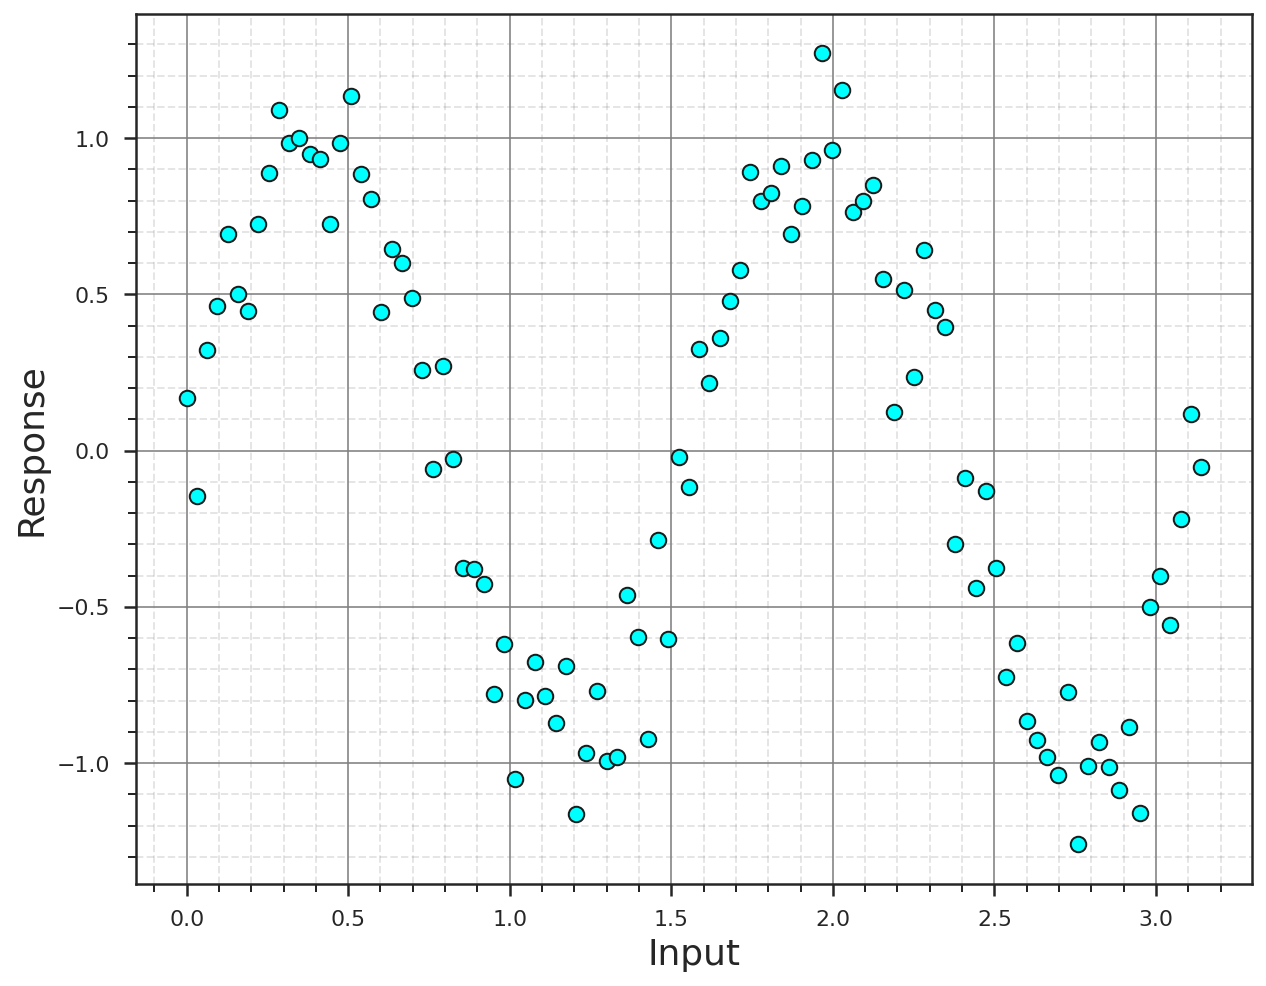

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Response',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [ ]:
polynomial_features= PolynomialFeatures(degree=8)
x_poly = polynomial_features.fit_transform(x.reshape(-1,1))

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

0.21782123636530457
0.9097482430147134


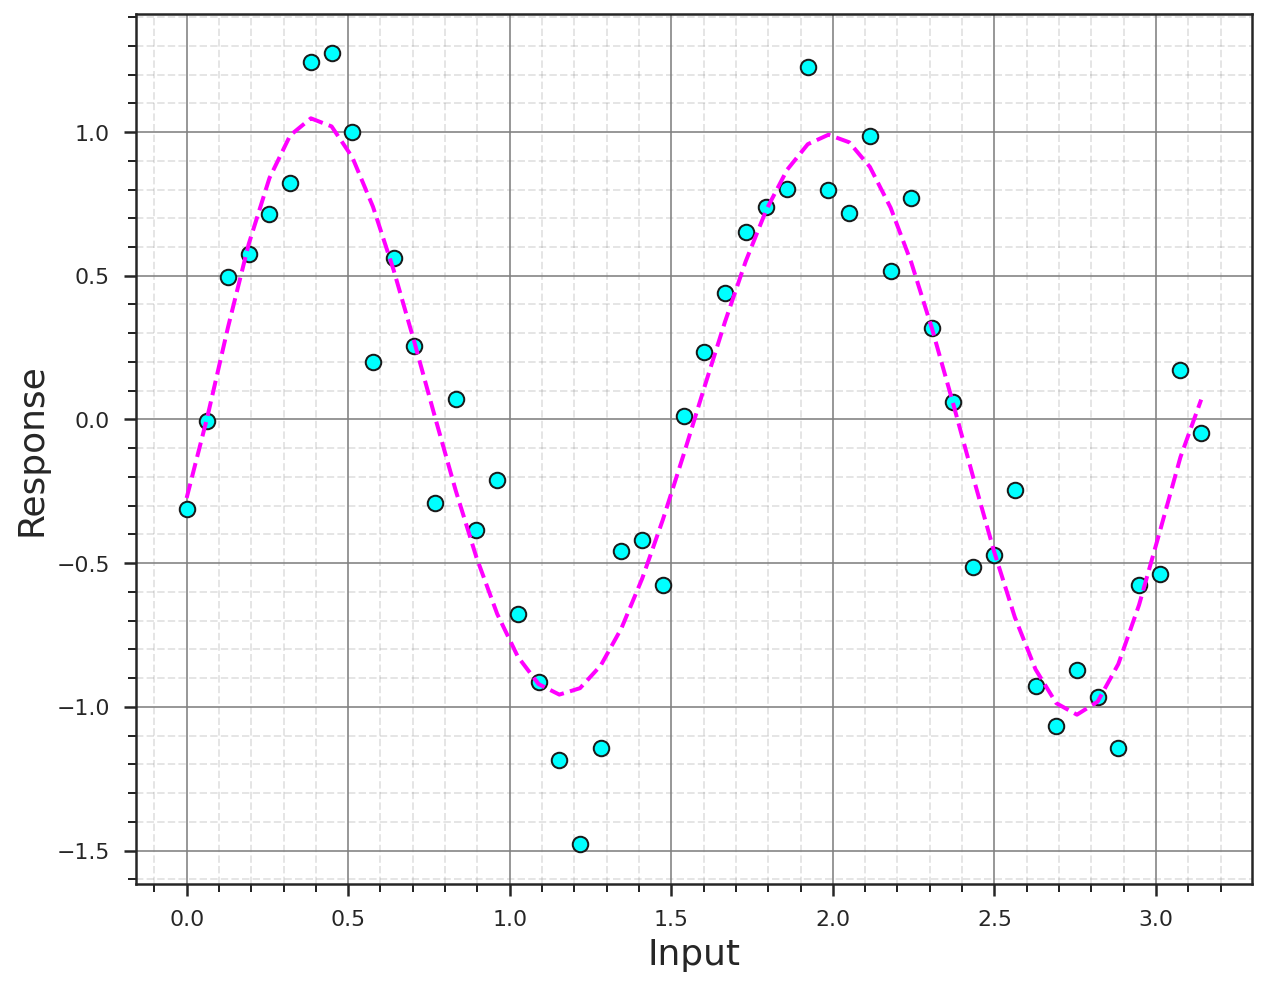

In [ ]:
fig, ax =plt.subplots(figsize=(10,8))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
xp, y_poly_pred = zip(*sorted_zip)
plt.plot(xp, y_poly_pred, color='magenta',linestyle='--',lw=2)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Response',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

## <font color='blue'> How do we know we are on the right track?

  - Use Train and Test Sets
  - Use Regularization.
  - Compute and (R)MSE on the test set.
  - Compute the coefficient of determination $R^2$ on the test set.
  - Determine the normality of the residuals by using a test statistic (such as Shapiro-Wilk or Kolmogorov-Smirnov), density plots and *quantile-quantile* plots.


##<font color= 'navy'> Model Validation via k-Fold Cross-Validations</font>

In order to compare the predictive power of different models we use K-fold cross-validation.

Example schematic of a 5-fold cross-validation:

<figure>
<center>
<img src='https://drive.google.com/uc?id=1AMSDtgJ-ADYjWFbHCdumvIGqUsmKSzdW' 
width='550px' />
<figcaption>Step 1 in the 5-fold cross-validation</figcaption></center>
</figure>



In [ ]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
scale = StandardScaler()

In [ ]:
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=5, random_state=1234,shuffle=True) # Define the split - into n_splits=.. folds 
kf.get_n_splits(df) # returns the number of splitting iterations in the cross-validator

5

In [ ]:
model = LinearRegression()

In [ ]:
polynomial_features= PolynomialFeatures(degree=3)

In [ ]:
np.random.seed(1693)
x = 2 - 3 * np.random.normal(0, 1, 100)

# this was the ground truth
def f(x):
    sz = len(x)
    return x - 2.5 * (x ** 2) + .25 * (x ** 3) + 2 * np.random.normal(-3, 3, sz)

y = f(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2021)
x_poly_train = polynomial_features.fit_transform(np.array(x_train).reshape(-1,1))
x_poly_test = polynomial_features.fit_transform(np.array(x_test).reshape(-1,1))
model.fit(x_poly_train,y_train)
yhat_train = model.predict(x_poly_train)
yhat_test = model.predict(x_poly_test)
print('The MSE for the Train data is : '+str(mean_squared_error(y_train,yhat_train)))
print('The MSE for the Test data is : '+str(mean_squared_error(y_test,yhat_test)))

The MSE for the Train data is : 28.722160563514002
The MSE for the Test data is : 70.81224647874207


In [ ]:
MSE_train = []
MSE_test = []
for idxtrain, idxtest in kf.split(x):
  x_train = x[idxtrain]
  x_test = x[idxtest]
  y_train = y[idxtrain]
  y_test  = y[idxtest]
  x_poly_train = polynomial_features.fit_transform(np.array(x_train).reshape(-1,1))
  x_poly_test = polynomial_features.fit_transform(np.array(x_test).reshape(-1,1))
  model.fit(x_poly_train,y_train)
  yhat_train = model.predict(x_poly_train)
  yhat_test = model.predict(x_poly_test)
  MSE_train.append(mean_squared_error(y_train,yhat_train))
  MSE_test.append(mean_squared_error(y_test,yhat_test))

In [ ]:
np.mean(MSE_train)

41.21171955908268

In [ ]:
columns = 'age sex bmi map tc ldl hdl tch ltg glu'.split() # Declare the columns names
diabetes = datasets.load_diabetes() # Call the diabetes dataset from sklearn
df = pd.DataFrame(diabetes.data, columns=columns) # load the dataset as a pandas data frame
y = diabetes.target # define the target variable (dependent variable) as y

In [ ]:
i = 0
PE = []

for train_index, test_index in kf.split(df):
    X_train = df.values[train_index]
    y_train = y[train_index]
    X_test = df.values[test_index]
    y_test = y[test_index]
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    PE.append(np.sqrt(MSE(y_test, y_pred)))
    print('Score:',np.sqrt(MSE(y_test, y_pred)))

np.mean(PE)

Score: 2.07564232825625e-14
Score: 2.53339911070645e-14
Score: 3.5649374396225664e-14
Score: 3.6946700750042225e-14
Score: 4.55244490049349e-14


3.2842187708165956e-14

In [ ]:
scale = StandardScaler()
lm = LinearRegression()

In [ ]:
pipe = Pipeline([('scale',scale),('lm',model)])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lm',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
pipe.predict(X_test)

array([61.89, 41.05, 44.3 , 38.07, 47.81, 52.91, 40.56, 41.15, 55.26,
       43.7 , 35.08, 15.05, 40.86, 37.8 , 40.2 , 25.2 , 41.1 , 28.3 ,
       35.3 , 55.6 , 49.2 , 61.09, 59.8 , 61.8 , 56.7 , 74.7 , 66.  ,
       74.5 , 63.4 , 64.9 , 66.1 , 71.7 , 65.2 , 67.8 , 24.99, 25.72,
       33.96, 39.61, 24.48, 31.54, 53.9 , 17.84, 40.23, 40.86, 19.93,
       30.23, 24.92, 31.64, 42.55, 42.92, 29.93, 13.12, 13.62, 27.77,
       31.27, 43.5 , 48.67, 48.97, 39.94, 52.04, 44.14, 45.37, 42.29,
       60.32, 23.8 , 51.33, 36.99, 56.74, 33.73, 40.15, 30.45, 38.6 ,
       30.22, 37.27, 16.28, 36.3 , 78.8 , 41.37, 67.87, 12.18, 32.9 ,
       20.73, 39.16, 33.69, 37.81, 24.85, 44.64, 51.72, 51.26, 55.02,
       50.94, 44.28, 57.03, 25.02, 56.14, 34.77, 41.67, 44.03, 61.86,
       72.1 , 39.  , 74.36, 13.4 , 35.75, 38.61, 24.4 , 31.97, 39.44,
       33.08, 24.07, 38.7 ,  7.51, 19.77, 11.48, 10.73, 31.38, 27.04,
       32.04, 21.95,  9.31, 27.63, 32.92,  9.99, 14.2 , 38.21, 30.14,
       20.59, 27.87,